In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

In [28]:
from_date = datetime.datetime(2010, 6, 29) # 1277769600
today = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
csv_file = 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=' + from_date.strftime('%s') + '&period2=' + today.strftime('%s') + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = '../data/tsla_HistoricalData.csv'
max_age = datetime.timedelta(days=1)
if not os.path.exists(local_file) or today - datetime.datetime.fromtimestamp(os.path.getmtime(local_file)) > max_age:
    import urllib.request
    urllib.request.urlretrieve(csv_file, local_file)
df = pd.read_csv(csv_file, encoding='cp1252', usecols=['Date', 'Adj Close'])


In [29]:
df.rename(columns={'Price': 'Pre-split Price'}, inplace=True)
df.rename(columns={'Adj Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_values(by='Date', ascending=True, inplace=True)
df.head()

,Price
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [30]:
csv_file = '../data/tsla_OtherTarget.csv'
dfOther = pd.read_csv(csv_file)
dfOther['Date'] = pd.to_datetime(dfOther['TargetDate'],dayfirst=True)
dfOther['ForecastDate'] = pd.to_datetime(dfOther['ForecastDate'],dayfirst=True)
dfOther.set_index('Date', inplace=True)
dfOther = dfOther.sort_index()
print(dfOther.columns)
#grouped = dfOther.groupby(['Source','ForecastDate'])

Index(['Year', 'Source', 'Bear', 'Base', 'Bull', 'ForecastDate', 'TargetDate',
       'Note'],
      dtype='object')


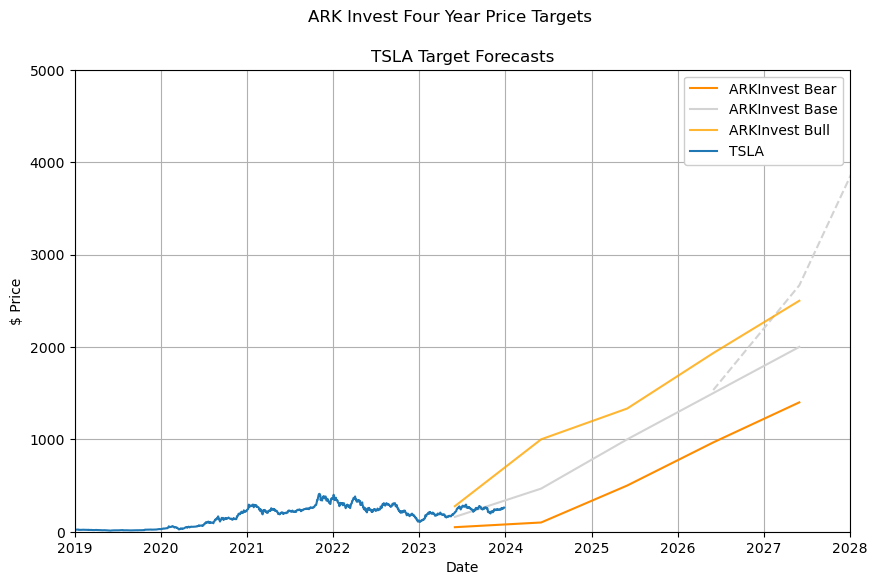

In [39]:
import matplotlib.cm as cm
import numpy as np

# Extend the four year forecast to the end of the data
extendFourYear = False
# Show other forecasts (in addition to ARK)
showOther = False

if not showOther:
    dfOther = dfOther[dfOther['Source'] == 'ARKInvest']

plt.figure(figsize=(10, 6))
grouped = dfOther.groupby('Source')
colorGreen = plt.cm.Greens(np.linspace(0.2, 0.6, len(grouped)))
colorOrange = plt.cm.Oranges(np.linspace(0.2, 0.6, len(grouped)))

# ARK has multiple forward projections on this date and I want this as a forked dashed line
# to indicate that this was a continuation of a forecast
# This is temporary until I can find a better way to plot muliple projections from one source
forecast_date = pd.to_datetime('2022-04-14')  

for (source, group), colorGreen in zip(grouped, colorGreen):
    if group['Bear'].notna().any():  # Check if the group has any non-null values
        plt.plot(group.index, group['Bear'], label=source+' Bear', color='darkorange')

    if source == 'ARKInvest':
        baseColor = 'lightgrey'
    else:
        baseColor = colorGreen
    subgroup = group[group['ForecastDate'] == forecast_date]
    if not subgroup.empty:      
        plt.plot(subgroup.index, subgroup['Base'], color=baseColor, linestyle='--')
    subgroup = group[group['ForecastDate'] != forecast_date]
    if not subgroup.empty:      
        plt.plot(subgroup.index, subgroup['Base'], label=source+' Base', color=baseColor)

    if group['Bull'].notna().any():  # Check if the group has any non-null values
        plt.plot(group.index, group['Bull'], label=source+ ' Bull', color='orange', alpha=0.8)


colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df.index, df['Price'], color=colors[0]['color'], label='TSLA')
plt.xlabel('Date')
plt.ylabel('$ Price')
plt.suptitle('ARK Invest Four Year Price Targets')
plt.title('TSLA Target Forecasts')
plt.yticks(range(0, 100000, 1000))
plt.grid(True)

if extendFourYear:
    right_limit = pd.to_datetime('2031-01-01')
    top_limit = 11000
else:
    right_limit = pd.to_datetime('2028-01-01')
    top_limit = 5000
plt.ylim(bottom=0, top=top_limit) 
plt.xlim(left=pd.to_datetime('2019-01-01'), right=right_limit)

#plt.yscale('linear')
legend = plt.legend(loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()

### Disclaimer

Not financial advice: All content of this repository is for educational purposes only. No warranty or guarantee or forward looking statements of fit for purpose; do your own research, etc.